In [1]:
import numpy as np
from pathlib import Path
from minerva.data.readers.tiff_reader import TiffReader
from minerva.data.readers.png_reader import PNGReader
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go

In [2]:
predictions_path = Path(".")
images_path = Path("/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/images/test")
annotations_path = Path("/workspaces/HIAAC-KR-Dev-Container/shared_data/seam_ai_datasets/seam_ai/annotations/test")

In [3]:
image_reader = TiffReader(images_path) # type: ignore
annotation_reader = PNGReader(annotations_path)

X = [image_reader[i] for i in range(len(image_reader))]
y = [annotation_reader[i] for i in range(len(annotation_reader))]

In [4]:
X = np.array(X).astype(np.float32)
y = np.array(y).astype(np.int32)

print(f"X shape: {X.shape}, y shape: {y.shape}")

X shape: (200, 1006, 590, 3), y shape: (200, 1006, 590)


In [5]:
models_predictions = {}
for f in sorted(predictions_path.glob("*.npy")):
    model_name = f.stem
    data = np.load(f)
    models_predictions[model_name] = data
    print(f"{model_name:<20}: {data.shape} ({data.dtype})")

byol_resnet50       : (200, 1006, 590) (int32)
dinov2_dpt          : (200, 1006, 590) (int32)
dinov2_mla          : (200, 1006, 590) (int32)
dinov2_pup          : (200, 1006, 590) (int32)
fastsiam_resnet50   : (200, 1006, 590) (int64)
sam                 : (200, 1006, 590) (int32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


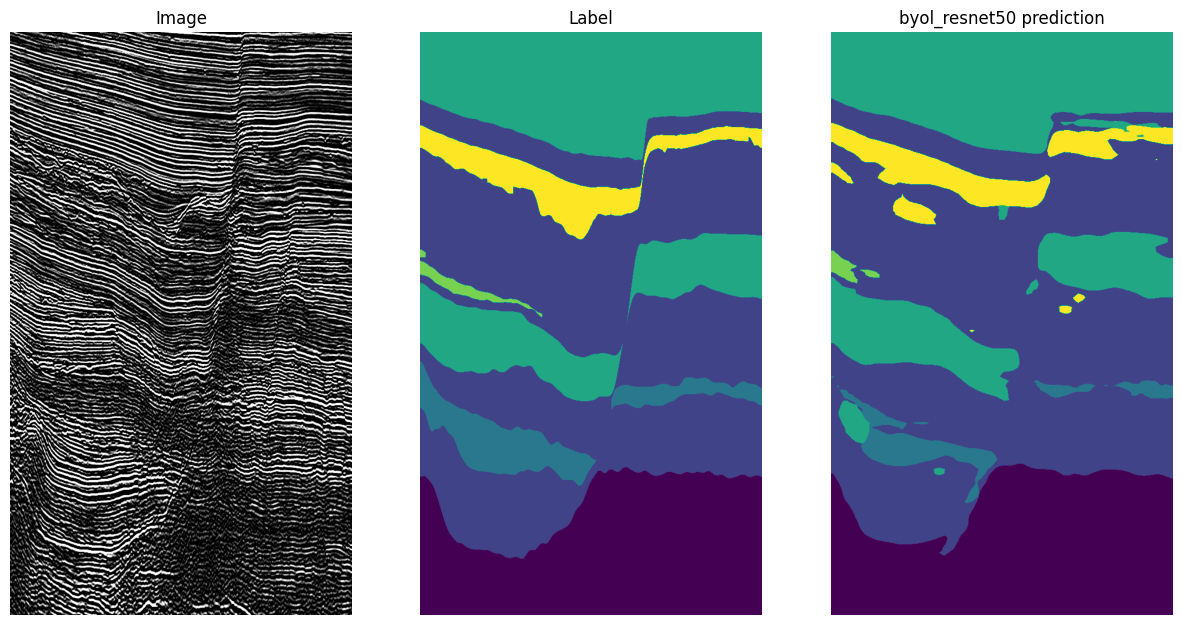

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


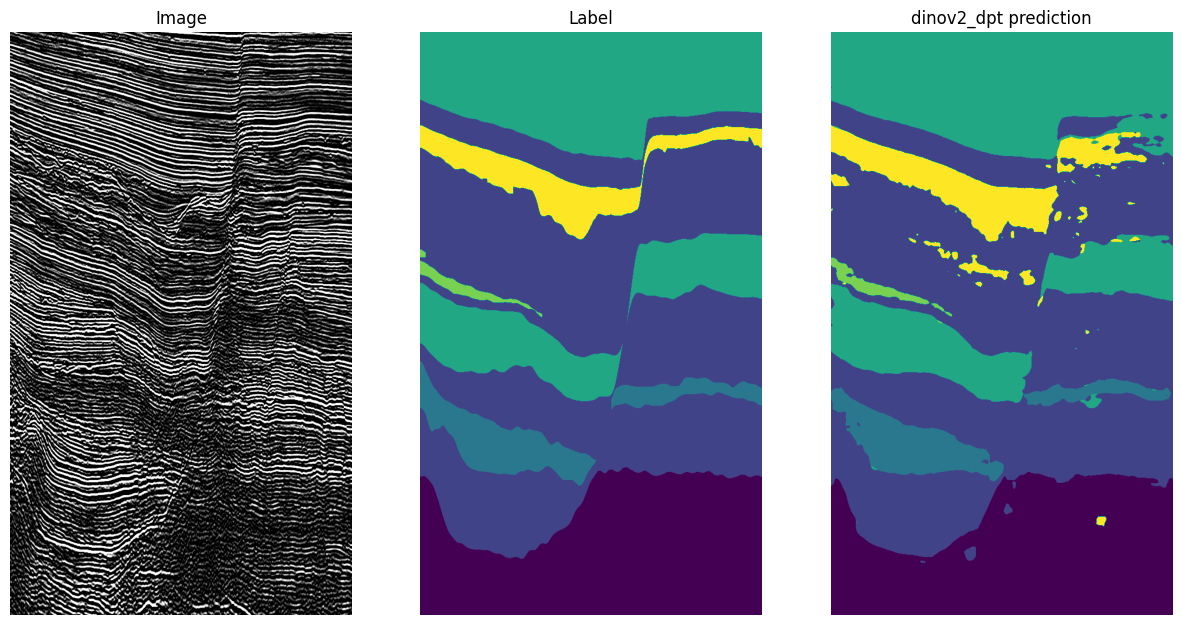

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


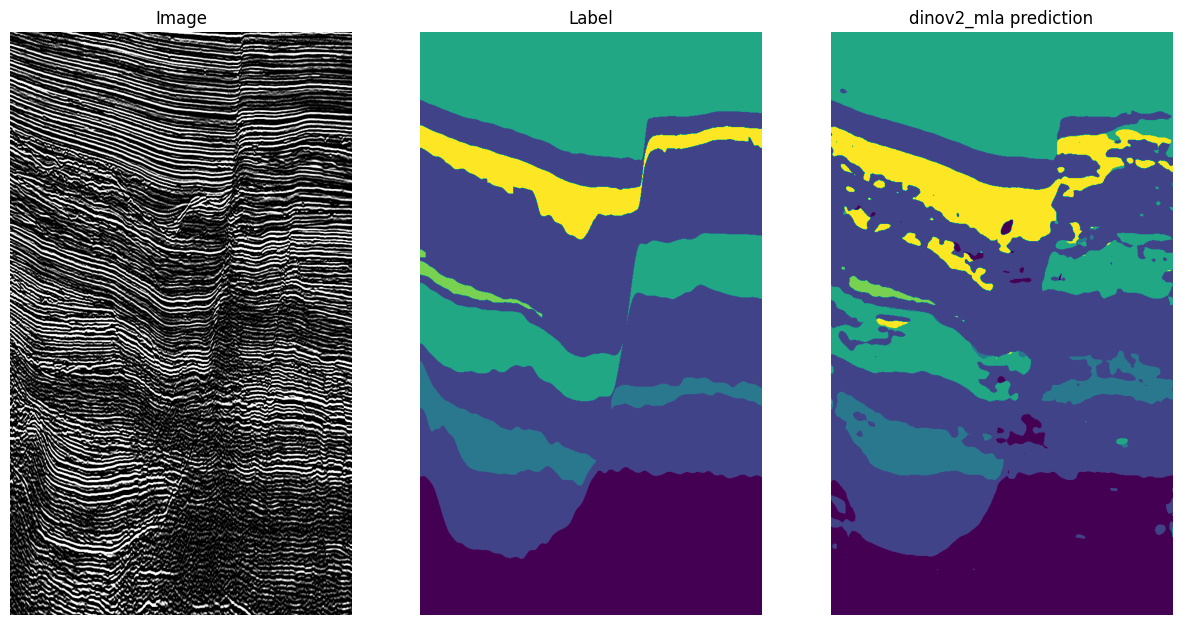

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


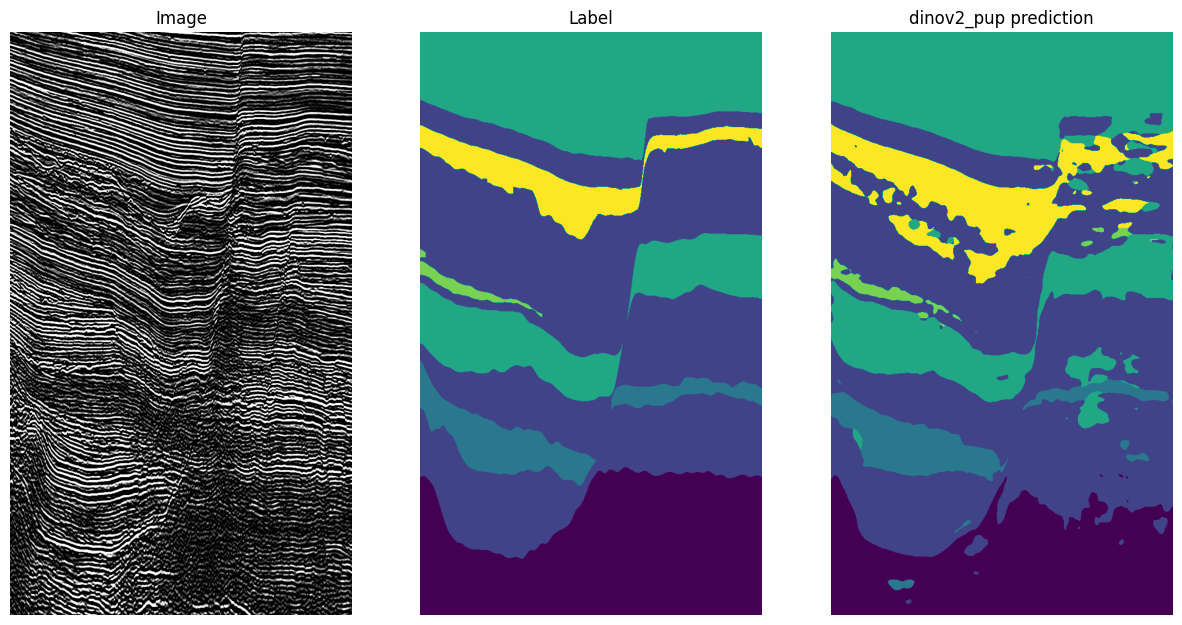

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


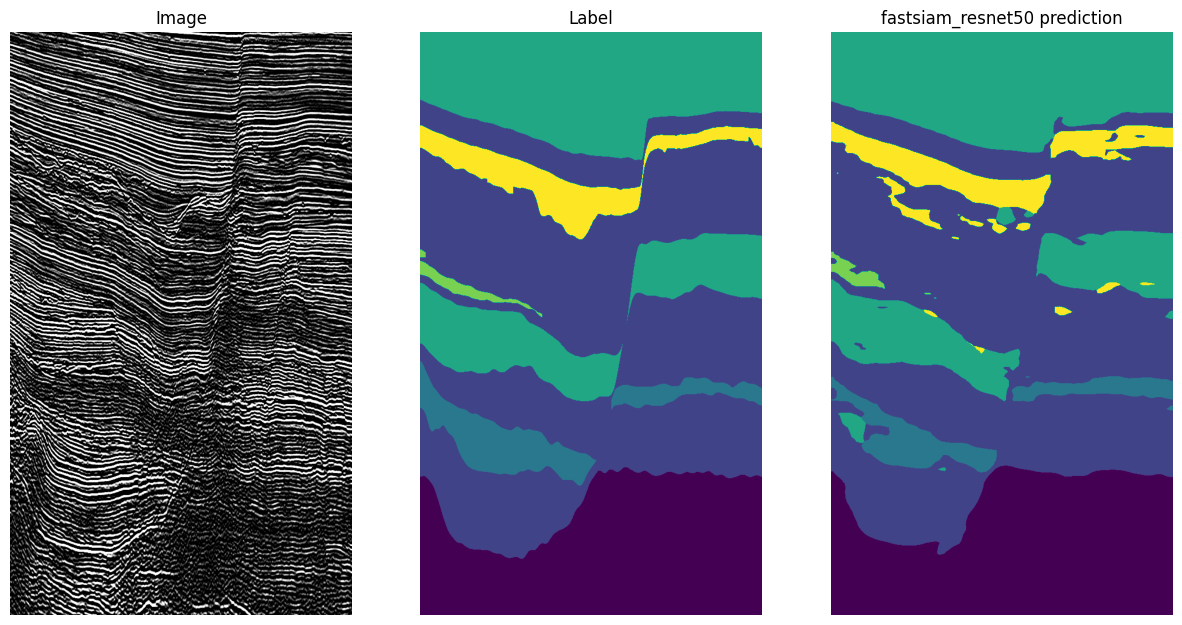

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


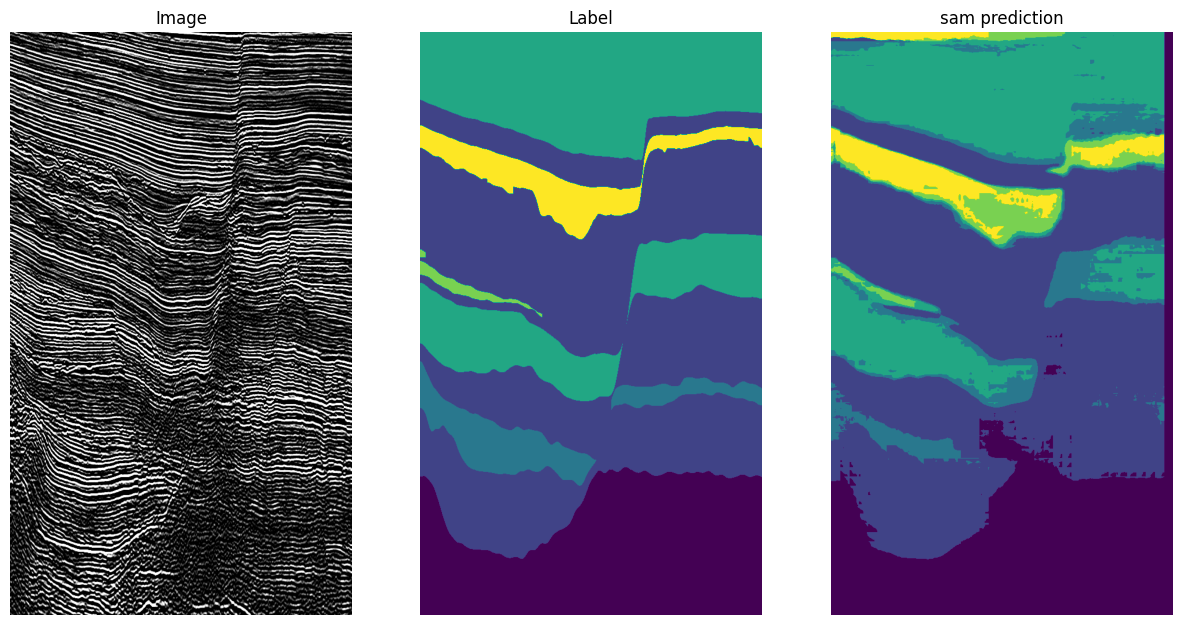

In [6]:
img_no = 100

import matplotlib.pyplot as plt

for model_name, predictions in models_predictions.items():
    plt.figure(figsize=(15, 10))
    plt.subplot(1, 3, 1)
    plt.imshow(X[img_no])
    plt.title("Image")
    plt.axis("off")
    
    plt.subplot(1, 3, 2)
    plt.imshow(y[img_no])
    plt.title("Label")
    plt.axis("off")
    
    plt.subplot(1, 3, 3)
    plt.imshow(predictions[img_no])
    plt.title(f"{model_name} prediction")
    plt.axis("off")
    
    plt.show()

In [7]:
import torchmetrics
import torch


metric = torchmetrics.JaccardIndex(task="multiclass", num_classes=6).to("cuda")
y = torch.tensor(y, requires_grad=False).to("cuda")
models_mious = {}


for model_name, preds in models_predictions.items():
    mious = []
    for i, p in enumerate(preds):
        preds = torch.tensor(p, requires_grad=False).to("cuda")
        mious.append(metric(preds, y[i]).item())
    
    models_mious[model_name] = np.array(mious)
    print(f"{model_name:<20}: {models_mious[model_name].mean():.4f} (min={models_mious[model_name].min():.4f}, max={models_mious[model_name].max():.4f})")

byol_resnet50       : 0.5512 (min=0.3079, max=0.8532)
dinov2_dpt          : 0.6426 (min=0.3486, max=0.8182)
dinov2_mla          : 0.5894 (min=0.3871, max=0.7499)
dinov2_pup          : 0.5514 (min=0.3206, max=0.7284)
fastsiam_resnet50   : 0.5716 (min=0.3080, max=0.8549)
sam                 : 0.3903 (min=0.3160, max=0.4857)


In [8]:
mious_df = pd.DataFrame(models_mious)
mious_df["index"] = np.arange(len(mious_df))
mious_df["mean"] = mious_df.mean(axis=1)
mious_df = mious_df.sort_values("mean", ascending=False)
mious_df

byol_resnet50  dinov2_dpt  dinov2_mla  dinov2_pup  fastsiam_resnet50  \
199       0.656388    0.654301    0.570894    0.520275           0.684167   
198       0.652678    0.643044    0.571806    0.519090           0.686617   
197       0.593154    0.639632    0.570358    0.511327           0.571492   
196       0.622786    0.637976    0.570140    0.503947           0.606302   
195       0.615011    0.638965    0.566520    0.497949           0.592201   
..             ...         ...         ...         ...                ...   
4         0.630777    0.643171    0.586927    0.532421           0.607713   
3         0.603136    0.655523    0.579078    0.521653           0.584857   
2         0.420882    0.551303    0.510616    0.470552           0.413976   
1         0.467859    0.529850    0.506622    0.456303           0.479937   
0         0.307938    0.348625    0.387068    0.320620           0.307997   

          sam  index       mean  
199  0.391421    199  28.925349  
198  0.389221    198  28.780351  
197  0.393090    197  28.611293  
196  0.396324    196  28.476782  
195  0.394338    195  28.329283  
..        ...    ...        ...  
4    0.393201      4   1.056316  
3    0.392342      3   0.905227  
2    0.346257      2   0.673369  
1    0.349864      1   0.541491  
0    0.315975      0   0.284032  

[200 rows x 8 columns]

In [9]:
best_inline = mious_df.iloc[0]
mean_inline = mious_df.iloc[len(mious_df) // 2]
worst_inline = mious_df.iloc[-1]

inlines = {
    "best": best_inline,
    "mean": mean_inline,
    "worst": worst_inline
}

print(inlines)

{'best': byol_resnet50          0.656388
dinov2_dpt             0.654301
dinov2_mla             0.570894
dinov2_pup             0.520275
fastsiam_resnet50      0.684167
sam                    0.391421
index                199.000000
mean                  28.925349
Name: 199, dtype: float64, 'mean': byol_resnet50         0.807622
dinov2_dpt            0.801799
dinov2_mla            0.725719
dinov2_pup            0.680913
fastsiam_resnet50     0.822225
sam                   0.476322
index                99.000000
mean                 14.759229
Name: 99, dtype: float64, 'worst': byol_resnet50        0.307938
dinov2_dpt           0.348625
dinov2_mla           0.387068
dinov2_pup           0.320620
fastsiam_resnet50    0.307997
sam                  0.315975
index                0.000000
mean                 0.284032
Name: 0, dtype: float64}


In [ ]:

import matplotlib.pyplot as plt

for inline_name, inline_info in inlines.items():
    img_no = int(inline_info["index"])
    for model_name, predictions in models_predictions.items():
        filename = f"{inline_name}_{img_no}_{model_name}_prediction.png"
        miou = inline_info[model_name]
        prediction = predictions[img_no]
        
        plt.figure(figsize=(5, 5))
        plt.imshow(predictions[img_no])
        plt.title(f"{model_name} (mIoU: {miou*100:.2f}%)")
        plt.axis("off")
        plt.tight_layout()
        plt.savefig(filename)
        print(f"Figure saved to {filename}")
        plt.close()
        
    plt.figure(figsize=(5, 5))
    plt.imshow(y[img_no].cpu().numpy())
    plt.title("Label")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{inline_name}_{img_no}_label.png")
    print(f"Figure saved to {inline_name}_{img_no}_label.png")
    plt.close()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(X[img_no])
    plt.title("Image")
    plt.axis("off")
    plt.tight_layout()
    plt.savefig(f"{inline_name}_{img_no}_image.png")
    print(f"Figure saved to {inline_name}_{img_no}_image.png")
    plt.close()

Figure saved to best_199_byol_resnet50_prediction.png
Figure saved to best_199_dinov2_dpt_prediction.png
Figure saved to best_199_dinov2_mla_prediction.png
Figure saved to best_199_dinov2_pup_prediction.png
Figure saved to best_199_fastsiam_resnet50_prediction.png
Figure saved to best_199_sam_prediction.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved to best_199_label.png
Figure saved to best_199_image.png
Figure saved to mean_99_byol_resnet50_prediction.png
Figure saved to mean_99_dinov2_dpt_prediction.png
Figure saved to mean_99_dinov2_mla_prediction.png
Figure saved to mean_99_dinov2_pup_prediction.png
Figure saved to mean_99_fastsiam_resnet50_prediction.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved to mean_99_sam_prediction.png
Figure saved to mean_99_label.png
Figure saved to mean_99_image.png
Figure saved to worst_0_byol_resnet50_prediction.png
Figure saved to worst_0_dinov2_dpt_prediction.png
Figure saved to worst_0_dinov2_mla_prediction.png
Figure saved to worst_0_dinov2_pup_prediction.png
Figure saved to worst_0_fastsiam_resnet50_prediction.png


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved to worst_0_sam_prediction.png
Figure saved to worst_0_label.png
Figure saved to worst_0_image.png


In [11]:
sorted_mious = {
    model_name: np.sort(mious, axis=0) for model_name, mious in models_mious.items()
}

sorted_mious_df = pd.DataFrame(sorted_mious)
sorted_mious_df.describe()

byol_resnet50  dinov2_dpt  dinov2_mla  dinov2_pup  fastsiam_resnet50  \
count     200.000000  200.000000  200.000000  200.000000         200.000000   
mean        0.551155    0.642601    0.589439    0.551366           0.571599   
std         0.098954    0.091615    0.074891    0.078717           0.102149   
min         0.307938    0.348625    0.387068    0.320620           0.307997   
25%         0.479759    0.556967    0.525093    0.483247           0.489898   
50%         0.516615    0.630199    0.577962    0.533479           0.545922   
75%         0.615184    0.698580    0.636908    0.616303           0.642642   
max         0.853188    0.818211    0.749929    0.728397           0.854855   

              sam  
count  200.000000  
mean     0.390333  
std      0.046614  
min      0.315975  
25%      0.348147  
50%      0.391928  
75%      0.414750  
max      0.485720

In [12]:
fig = px.line(sorted_mious_df, labels={"index": "Crosslines (sorted from worst to best MIOU)", "value": "MIoU"}, width=1000, height=600)
fig.update_layout(
    legend=dict(
        title="Model",
        orientation="h",
        yanchor="top",
        y=1.10,
        xanchor="center",
        x=0.5
    ),   # margin=dict(l=10, r=10, t=10, b=10),
)

fig.write_image("sorted_mious.png")
fig.show()

In [13]:
print(mious_df[["byol_resnet50", "dinov2_dpt", "dinov2_mla", "dinov2_pup", "fastsiam_resnet50", "sam"]].mean().to_markdown())

|                   |        0 |
|:------------------|---------:|
| byol_resnet50     | 0.551155 |
| dinov2_dpt        | 0.642601 |
| dinov2_mla        | 0.589439 |
| dinov2_pup        | 0.551366 |
| fastsiam_resnet50 | 0.571599 |
| sam               | 0.390333 |


In [14]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go

for name in mious_df.columns:
    # Create the horizontal heat map
    fig = go.Figure(data=go.Heatmap(
        z=mious_df[name].values.reshape(1, -1),
        colorscale='Blues',
        showscale=True,
        zmin=0.3,
        zmax=0.9
    ))

    # Update layout to make it horizontal
    fig.update_layout(
        title=name,
        xaxis=dict(title='Index', showgrid=False),
        yaxis=dict(title='mIoU', showticklabels=False),  
        height=200,
        width=800,
        xaxis_nticks=30,
        xaxis_title="Crossline Index",
        margin=dict(l=10, r=10, t=30, b=10),
        
    )
    
    fname = f"heatmap_{name}.png"

    fig.write_image(fname)
    print(f"Figure saved to {fname}")

    # Display the heat map
    fig.show()


Figure saved to heatmap_byol_resnet50.png


Figure saved to heatmap_dinov2_dpt.png


Figure saved to heatmap_dinov2_mla.png


Figure saved to heatmap_dinov2_pup.png


Figure saved to heatmap_fastsiam_resnet50.png


Figure saved to heatmap_sam.png


Figure saved to heatmap_index.png


Figure saved to heatmap_mean.png
